In [1]:
# imports #
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from stability import stability
from tqdm.auto import trange

device = 'cuda'
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
def noisy_batch1d(imgs, timgs):
    """
    :param imgs: original images
    :param timgs: locally translated images / diffeo
    :return: original images, locally translated images, noisy images
    """
    sigma = (timgs - imgs).pow(2).sum([1], keepdim=True).sqrt()
    eta = torch.randn(imgs.shape, device=imgs.device)
    eta = eta / eta.pow(2).sum([1], keepdim=True).sqrt() * sigma
    nimgs = imgs + eta
    return nimgs

class ConstantFiltersCNN(nn.Module):
    def __init__(self, kernel_size, stride, depth, one_filters=0):
        super(ConstantFiltersCNN, self).__init__()
        self.k = kernel_size
        self.s = stride
        self.L = depth
        self.one = one_filters
                
    def forward(self, x):
        
        filters_value = 1 if self.one else self.s / self.k

        for i in range(self.L):
            x = x.unfold(1, self.k, self.s).sum(-1).mul(filters_value).relu()
        return x

## Compute stabilities of a CNN with constant filters on the two-pixels model

Parameters

In [3]:
N = 512
L = 64
kernel_size = 3
stride = 1
seeds = 10

In [4]:
x = torch.eye(N, device=device)
xd = x.roll(1, 1)

f = ConstantFiltersCNN(kernel_size=kernel_size, stride=stride, depth=L)
f = f.to(device)
nodes, _ = get_graph_node_names(f)
nodes = [n for n in nodes if 'relu' in n]
l = create_feature_extractor(f, return_nodes=nodes)
with torch.no_grad():
    o = l(x)
    od = l(xd)

In [5]:
df = []

for seed in trange(seeds):
    xn = noisy_batch1d(x, xd)
    xn = xn.relu()
    with torch.no_grad():
        on = l(xn)
        
    for i, k in enumerate(o):
        D, deno = stability(o[k], od[k])
        G, _ = stability(o[k], on[k])

        df.append({
            'seed': seed,
            'layer': k,
            'li': i,
            'D': D,
            'G': G,
            'deno': deno,
        })
df = pd.DataFrame.from_records(df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
df1 = df[df.apply(lambda a: 'relu' in a.layer, axis=1)]

groups = ['li']
D = df1.groupby(groups)['D'].apply(np.mean)
G = df1.groupby(groups)['G'].apply(np.mean)
deno = df1.groupby(groups)['deno'].apply(np.mean)

Nums and deno

<IPython.core.display.Javascript object>


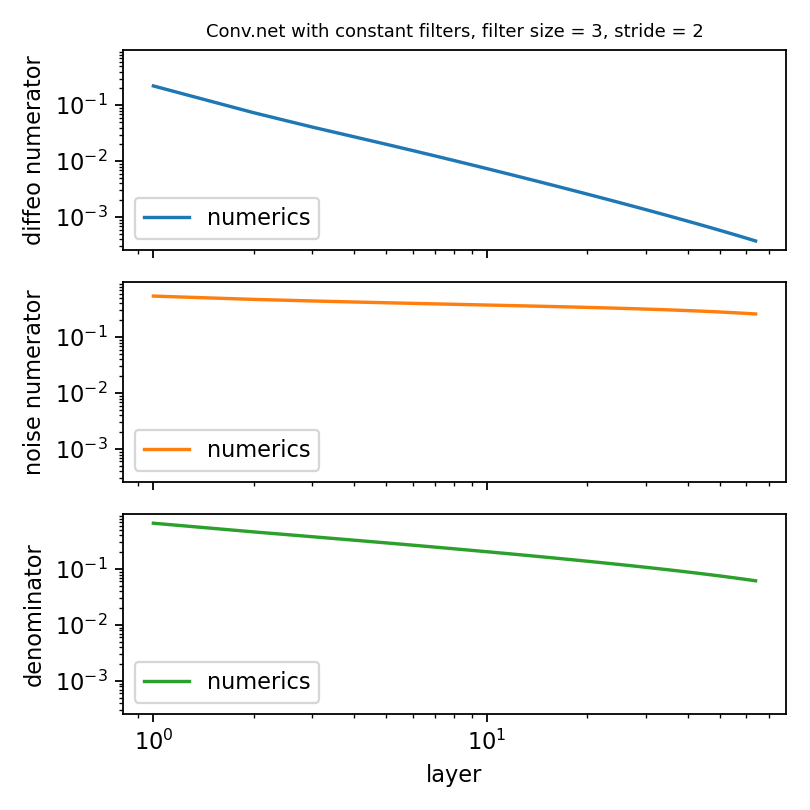

In [13]:
%matplotlib notebook

_, ax = plt.subplots(3, 1, figsize=(5, 5), dpi=180, sharex=True, sharey=True)

ls = torch.arange(1, L + 1).float()

plt.sca(ax[0])
plt.title(f'Conv.net with constant filters, filter size = {kernel_size}, stride = {stride}', fontsize=8) # \n (ReLU at input)
plt.plot(ls, D, 'C0', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1.5, '--C0', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, 2 ** (-ls), '--C0', label='prediction, $2^k$')
elif kernel_size >= 4:
    plt.plot(ls, kernel_size ** (-ls), '--C0', label='prediction, $f_s^{-k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('diffeo numerator')

plt.sca(ax[1])
plt.plot(ls, G, 'C1', label='numerics')
if stride == 1:
    plt.plot(ls, .4 * torch.ones(L), '--C1', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, 2 ** (ls), '--C1', label='prediction, $2^{-k}$')
elif kernel_size >= 4:
    plt.plot(ls, stride ** (ls) / 4, '--C1', label='prediction, $s^{k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('noise numerator')

plt.sca(ax[2])
plt.plot(ls, deno, 'C2', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -.5, '--C2', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
elif kernel_size >= 4:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
#     plt.ylim(1e-5, 5)
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('denominator')
plt.xlabel('layer')

plt.tight_layout()

Stabilities: $D_f$, $G_f$, $R_f$

<IPython.core.display.Javascript object>


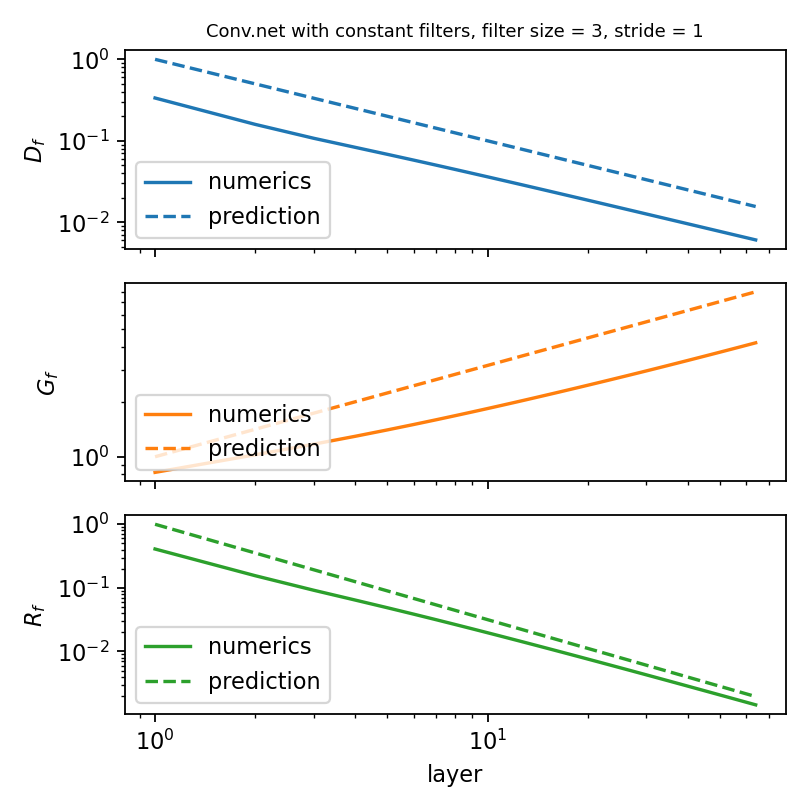

In [8]:
%matplotlib notebook

_, ax = plt.subplots(3, 1, figsize=(5, 5), dpi=180, sharex=True, sharey=False)

ls = torch.arange(1, L + 1).float()

plt.sca(ax[0])
plt.title(f'Conv.net with constant filters, filter size = {kernel_size}, stride = {stride}', fontsize=8) # \n (ReLU at input)
plt.plot(ls, D / deno, 'C0', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1, '--C0', label='prediction')
elif stride == 2 and kernel_size == 2 or kernel_size >= 3:
    plt.plot(ls, 2 ** (-ls), '--C0', label='prediction, $2^k$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$D_f$')

plt.sca(ax[1])
plt.plot(ls, G / deno, 'C1', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** .5, '--C1', label='prediction')
elif stride == 2 and kernel_size == 2 or kernel_size >= 3:
    plt.plot(ls, 2 ** (ls), '--C1', label='prediction, $2^{-k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$G_f$')

plt.sca(ax[2])
plt.plot(ls, D / G, 'C2', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1.5, '--C2', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$R_f$')
plt.xlabel('layer')

plt.tight_layout()

# Compute receptive field

Parameters

In [9]:
filter_size = 4
stride = 2
depth = 4
input_size = 64

In [10]:
f = ConstantFiltersCNN(filter_size, stride, depth, one_filters=1)
x = torch.eye(input_size, device=device)

In [11]:
layers, _ = get_graph_node_names(f)
layers = [l for l in layers if 'relu' in l]
features = create_feature_extractor(f, return_nodes=layers)
out = features(x)
for k in layers:
    out[k] = out[k].t()

In [12]:
for k in layers:
    i = out[k].shape[0] // 2
    a = out[k][i]
    for ai in a:
        print(int(ai.item()), end=' ')
    print(f' | RF: {sum(a > 0)}')
    
    for ai in a.diff():
        print(int(ai.item()), end=' ')
    print(f' | df: {sum(a.diff().pow(2).int()) / sum(a > 0):.02f}')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | RF: 4
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | df: 0.50
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | RF: 10
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 -1 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | df: 0.40
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3 4 4 4 4 4 4 4 4 4 4 3 3 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | RF: 22
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 -1 0 -1 0 -1 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | df: 0.36
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 7 6 6 5 5 4 4 3 3 2 2 1 1 0 0  | RF: 46
0 0 0 0 0 0 0 0 0 0 0 0 0 0 